<a href="https://colab.research.google.com/github/MeinHserhT/CS14115/blob/main/Report_Parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC14116 - Changing image background

## Tổng quan
Làm mờ hay thay đổi background (hậu cảnh) là một trong những ứng dụng cần thiết trong bối cảnh hậu đại dịch Covid, khi mà ngày càng nhiều cuộc họp được thực hiện trực tuyến do sự tiện lợi của nó mà người dùng muốn có một không gian họp riêng tư ngay tại nơi mình đang ngồi mà không cần phải di chuyển đến một nơi khác.

Việc thay đổi background được nhóm xác định gồm 2 bước chính:
 1. Xác định phần khung viền bọc xung quanh người.
 2. Tùy theo làm mờ hay thay đổi background mà có thể nhân ma trận để làm mờ hoặc ghép hình người vào một khung cảnh khác.

## Động lực
Chúng tôi thấy việc thay đổi background là một tính năng cần thiết cho các ứng dụng họp online được sử dụng rộng rãi trong thời đại công nghệ hiện nay. Bên cạnh đó nhóm nhận thấy công việc này cũng có thể phân ra thành các bước áp dụng được song song hóa, từ đó cải thiện tốc độ xử lý vấn đề.

## Vì sao cần tăng tốc?
Việc thay đổi background nếu được thực hiện tuần tự trên CPU sẽ làm tốn rất nhiều thời gian do mỗi giây trên video tạo từ rất nhiều khung hình, mà mỗi khung đều có thể được quy về các bước để chạy song song mà CPU không thích hợp để chạy song song. Vì thể chúng tôi mong muốn có thể giả lập lại việc thay đổi background chạy song song trên GPU để tăng tốc quá trình xử lý, từ đó có thể đạt được hiệu năng như các ứng dụng họp online như Zoom, Google Meet, ...

## Khả năng chạy song song
1. Việc xác định khung viền bọc xung quanh người được thực hiện bằng việc đưa các khung hình qua model đã được huấn luyện trước. Mỗi khung hình được đưa qua các tầng của model, mà công việc chính là nhân ma trận nên có thể thực hiện việc song song hóa, từ đó có thể thiết kế để chạy song song.
2. Việc thay đổi background cũng có thể được thực hiện song song do việc xác định phần background sẽ được thực hiện bằng việc nhân với ma trận được xác định ở bước 1, việc thay đổi background mới cũng được thực hiện bằng việc nhân ma trận nên có thể song song hoá.

$\rightarrow$ Do đó có thể thiết kế song song cho toàn bộ quá trình. 

**Input:** Hình ảnh, video người dùng trong các cuộc họp trực tuyến và hình ảnh background người dùng muốn thay thế.

**Output:** Hình ảnh, video đã được thay đổi background.


<img src="https://user-images.githubusercontent.com/50958253/174557063-b2699158-4098-4929-b501-bc23eb55f2b0.png" alt="drawing" width="200"/> + <img src="https://user-images.githubusercontent.com/50958253/174557523-737ec1d9-5514-4a00-9d6f-6b0440eaf718.png" alt="drawing" width="200"/>
 = <img src="https://user-images.githubusercontent.com/50958253/174557505-e5784dcb-51b3-4c77-b6a7-36073d5a4e35.png" alt="drawing" width="200"/>

*Nguồn ảnh*: https://www.youtube.com/watch?v=pBIunR98d5I&t=143s




## Hướng tiếp cận 
Dựa trên 2 bước chính:
1. Cài đặt quá trình feedforward với bộ trọng số đã huấn luyện của mô hình U-Net để giải quyết bài toán human segmentation.

   Các tầng layer chính: Conv2d, BatchNormalization, Activation('relu'), MaxPool2D, Conv2dTranspose. 
2. Thay thế các pixel thuộc lớp background với hình ảnh người dùng muốn thay thế.
 
**Tuần tự:** viết code cho các layer sử dụng numpy.

**Song song:** sử dụng numba để tối ưu hóa code tuần tự.     

![zoom5](https://user-images.githubusercontent.com/47071155/174651030-3d2a6216-8f11-4ee7-953e-9dae594b5348.jpg)
![zoom5](https://user-images.githubusercontent.com/47071155/174651046-1113c81a-2350-48c7-a774-5df50772c8cf.jpg)

_Ảnh kết quả khi xác định pixel của người dùng mô hình U-Net_

*Nguồn ảnh*: Google image



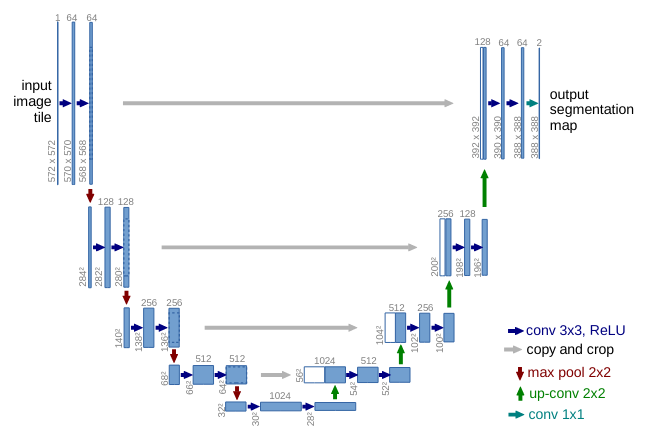 \
*Nguồn ảnh*: Olaf Ronneberger, Philipp Fischer, and Thomas Brox "U-Net: Convolutional Networks for Biomedical
Image Segmentation" in 2015

## Cài đặt tuần tự
Cài đặt sử dụng dòng lặp và câu điều kiện, không xài các hàm của numpy

### Thiết kế


Feature map dimension: $(1,w,h,d)$ \
**Activation("relu")** \
Công thức: $f(x) = max(0,x)$

*  Sử dụng 3 vòng lặp tương ứng với depth, width, height để duyệt ma trận và gán các giá trị < 0 thành 0.

**MaxPool2D** \
Tham khảo hướng giải quyết thông qua bài viết [1]

*   Tính kích thước và khởi tạo ma trận output:
 * $inputWidth = \frac{inputWidth - poolsize}{stride}+1$
 * $outputWidth = \frac{outputWidth - poolsize}{stride}+1$
*   Duyệt từng d của feature map
  - Sử dụng 2 dòng for để duyệt ma trận và áp dụng maxpool filter. Kết quả được cập nhật trong ma trận output.

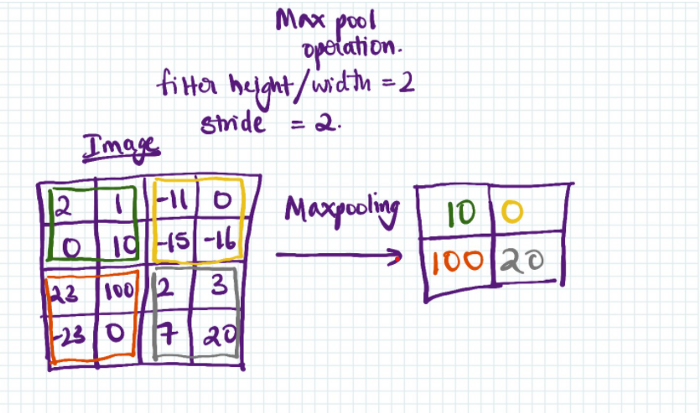

Nguồn ảnh: https://medium.com/@PAdhokshaja/simple-cnn-using-numpy-part-iii-relu-max-pooling-softmax-c03a3377eaf2

**Convolution 2D**

Convolution (lớp tích chập) là lớp trích xuất các đặc tính từ hình ảnh. Tham số lớp này bao gồm một tập hợp các bộ lọc đã được học. Các kernel có kích thước hai chiều đầu tiên đa số 3x3 và có độ sâu bằng với độ sâu của đầu vào. Bằng cách trượt dần bộ lọc theo chiều ngang và dọc trên ảnh, chúng ta sẽ thu được một feature map chứa các đặc trưng được trích xuất từ trên hình ảnh đầu vào.

<img src="https://i.stack.imgur.com/BZHGo.png" alt="drawing" width="512"/>

*Nguồn ảnh*: https://stackoverflow.com/questions/43306323/keras-conv2d-and-input-channels

**Convolution 2D Transpose**

### Cài đặt

#### Sử dụng thư viện kiểm tra

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CSC14116-LTSSUD

/content/drive/.shortcut-targets-by-id/1SL0rdRuV7v0Qa3mt_F5k1kFcCa1HCI7I/CSC14116-LTSSUD


In [ ]:
# Load model
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, MaxPool2D
import numpy as np
import cv2
from keras import backend as K

In [ ]:
pretrain_model = load_model('./Model/unet.h5')

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    # (256, 256, 3)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    outputs = MaxPool2D((2, 2))(x)

    """ Output """
    return Model(inputs, outputs, name="U-Net")

In [ ]:
# Read input and build model
x = read_image("/content/drive/MyDrive/CSC14116-LTSSUD/zoom5.jpg")
x = np.expand_dims(x, axis=0)

input_shape = (256, 256, 3)
model = build_unet(input_shape)

In [ ]:
# Load pretrain weights 
for i in range(1,3):
    exits_w = pretrain_model.layers[i].weights
    model.layers[i].set_weights(pretrain_model.layers[i].weights)

In [ ]:
%%capture
model(x)

In [ ]:
# Create variables for checking 
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function(inp, out) for out in outputs]    # evaluation functions

# Layers weights
layer_outs = [func(x) for func in functors]

#### Activation("relu")

In [ ]:
import time
from numba import jit, prange, config, cuda

In [ ]:
@jit(cache=True)
def relu_v1(x):
  for d in range(x.shape[3]):
    for i in range(x.shape[1]):
      for j in range(x.shape[1]):
        if x[:,i,j,d]<0:
          x[:,i,j,d]=0
  return x

In [ ]:
# Check  answer
before_ac = np.array(layer_outs[2])
after_ac = np.array(layer_outs[3])

%time ac_result = relu_v1(before_ac)
print("Checking difference",np.abs(ac_result-after_ac).sum())

CPU times: user 808 ms, sys: 13.9 ms, total: 822 ms
Wall time: 820 ms
Checking difference 0.0


In [ ]:
%time ac_result = relu_v1(before_ac)

CPU times: user 691 ms, sys: 4.97 ms, total: 696 ms
Wall time: 692 ms


|   |  Wall time |   
|---|---|
| 1st run  |  570 ms |  
| 2nd run  |  7.43 ms |

#### Activation Sigmoid

In [ ]:
@jit(cache=True)
def sig_v1(x):
  for d in range(x.shape[3]):
    for i in range(x.shape[1]):
      for j in range(x.shape[1]):
        x[:,i,j,d]= 1 / (1 + np.exp(-x[:,i,j,d]))
  return x 

In [ ]:
before_ac = np.array(layer_outs[2])
after_ac = 1 / (1 + np.exp(-layer_outs[2]))

%time ac_result = sig_v1(before_ac)
print("Checking difference",np.abs(ac_result-after_ac).sum())

CPU times: user 438 ms, sys: 337 µs, total: 439 ms
Wall time: 436 ms
Checking difference 0.05961182


#### MaxPool2D

In [ ]:
@jit(cache=True)
def maxpool2d_v1(x, pool_size = 2,stride = 2):
  # Input dim (1,256,256,3)
  output_width = output_height = int((x.shape[1]-pool_size)/stride)+1
  pooled = np.zeros((1,output_width,output_height,x.shape[3]))

  # Iterate over all pools
  for d in range(x.shape[3]):
    for i in range(0,x.shape[1], stride):
      for j in range(0, x.shape[1], stride):
        if i+pool_size <= x.shape[1] and j+pool_size <= x.shape[1]:
          mat = x[:,i:i+pool_size, j:j+pool_size, d]
          pooled[:,int(i/stride),int(j/stride),d]=np.max(mat)
        else:
          raise Exception("Out of index") 
      
  return pooled

In [ ]:
# Check  answer
before_maxpool = np.array(layer_outs[3])
after_maxpool = np.array(layer_outs[4])

%time maxpool2d_result = maxpool2d_v1(before_maxpool)
print("Checking difference",np.abs(maxpool2d_result-after_maxpool).sum())

CPU times: user 132 ms, sys: 268 µs, total: 132 ms
Wall time: 133 ms
Checking difference 0.0


In [ ]:
%time maxpool2d_result = maxpool2d_v1(before_maxpool)

CPU times: user 135 ms, sys: 51 µs, total: 135 ms
Wall time: 135 ms


|   |  Wall time |   
|---|---|
| 1st run  |  567 ms |  
| 2nd run  |  241 ms |

#### Conv2D

In [ ]:
@jit(cache=True)
def conv2D_v1(input, wei, bias, padding='none', stride=1):
    w_in, h_in, c_in = input.shape[1], input.shape[2], input.shape[3]
    k = wei.shape[1] # kernel size
    pad = int(k / 2) if (padding == 'same') else 0
    w_out = (w_in + 2 * pad - k)//stride + 1
    h_out = (h_in + 2 * pad - k)//stride + 1
    c_out = bias.shape[0]

    input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
    input_pad[:, pad:(w_in + pad), pad:(h_in + pad), :] = input[:, :, :, :]

    res=np.zeros((1, w_out, h_out, c_out))

    for x in range(w_out): 
        for y in range(h_out):
            for c_o in range(c_out):
                total=0
                for c_i in range(c_in):
                    kt=0
                    for k1 in range(k):
                        for k2 in range(k):
                            pos1 = k1 + x * stride
                            pos2 = k2 + y * stride
                            kt += wei[c_o, k1, k2, c_i] * input_pad[0, pos1, pos2, c_i]
                    total += kt
                res[0, x, y, c_o] = total + bias[c_o]
    return res

In [ ]:
%%time
before_conv = np.array(x)
after_conv = np.array(layer_outs[1])
weight = model.layers[1].weights[0].numpy().transpose((3, 0, 1, 2))
bias = model.layers[1].weights[1].numpy()

conv_res = conv2D_v1(before_conv, weight, bias, padding='same')
print("Checking difference",np.abs(conv_res-after_conv).sum())

Checking difference 0.039818200941747005
CPU times: user 201 ms, sys: 36.9 ms, total: 237 ms
Wall time: 235 ms


In [ ]:
%time conv_res = conv2D_v1(before_conv, weight, bias, padding='same')

CPU times: user 172 ms, sys: 167 µs, total: 172 ms
Wall time: 171 ms


#### Conv2D Transpose

In [ ]:
@jit(cache=True)
def trans_conv2D_v1(X, wei, bias, padding='same'):
  h, w = wei.shape[1], wei.shape[2]
  Y = np.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Y[i: i + h, j: j + w] += X[:,i, j] * wei
  return Y

In [ ]:
# %%time
# before_conv = np.array(layer_outs[1])
# after_conv = np.array(layer_outs[2])
# weight = model.layers[1].weights[0].numpy().transpose((3, 0, 1, 2))
# bias = model.layers[1].weights[1].numpy()

# trans_conv_res = trans_conv2D_v1(before_conv, weight, bias)
# print("Checking difference",np.abs(y-after_conv).sum())

In [ ]:
# %time trans_conv_res = trans_conv2D_v1(before_conv, weight, bias, padding='same')

#### Batch Normalization

In [ ]:
# def batch_norm_v1(X, gamma, beta, moving_mean, moving_var):
#   eps = 1e-5
#   X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
#   Y = gamma * X_hat + beta
#   return Y

In [ ]:
# %%time
# before_norm = np.array(layer_outs[1])
# after_norm = np.array(layer_outs[2])

# wei = model.layers[2].weights
# gamma = wei[0].numpy()
# beta = wei[1].numpy()
# moving_mean = wei[2].numpy()
# moving_var = wei[3].numpy()

# norm_result = batch_norm_v1(before_norm, gamma, beta, moving_mean, moving_var)
# print("Checking difference",np.abs(norm_result-after_norm).sum())

In [ ]:
# %time norm_result = batch_norm_v1(before_norm, gamma, beta, moving_mean, moving_var)

In [ ]:
### Đánh giá

#### Mô hình U-Net

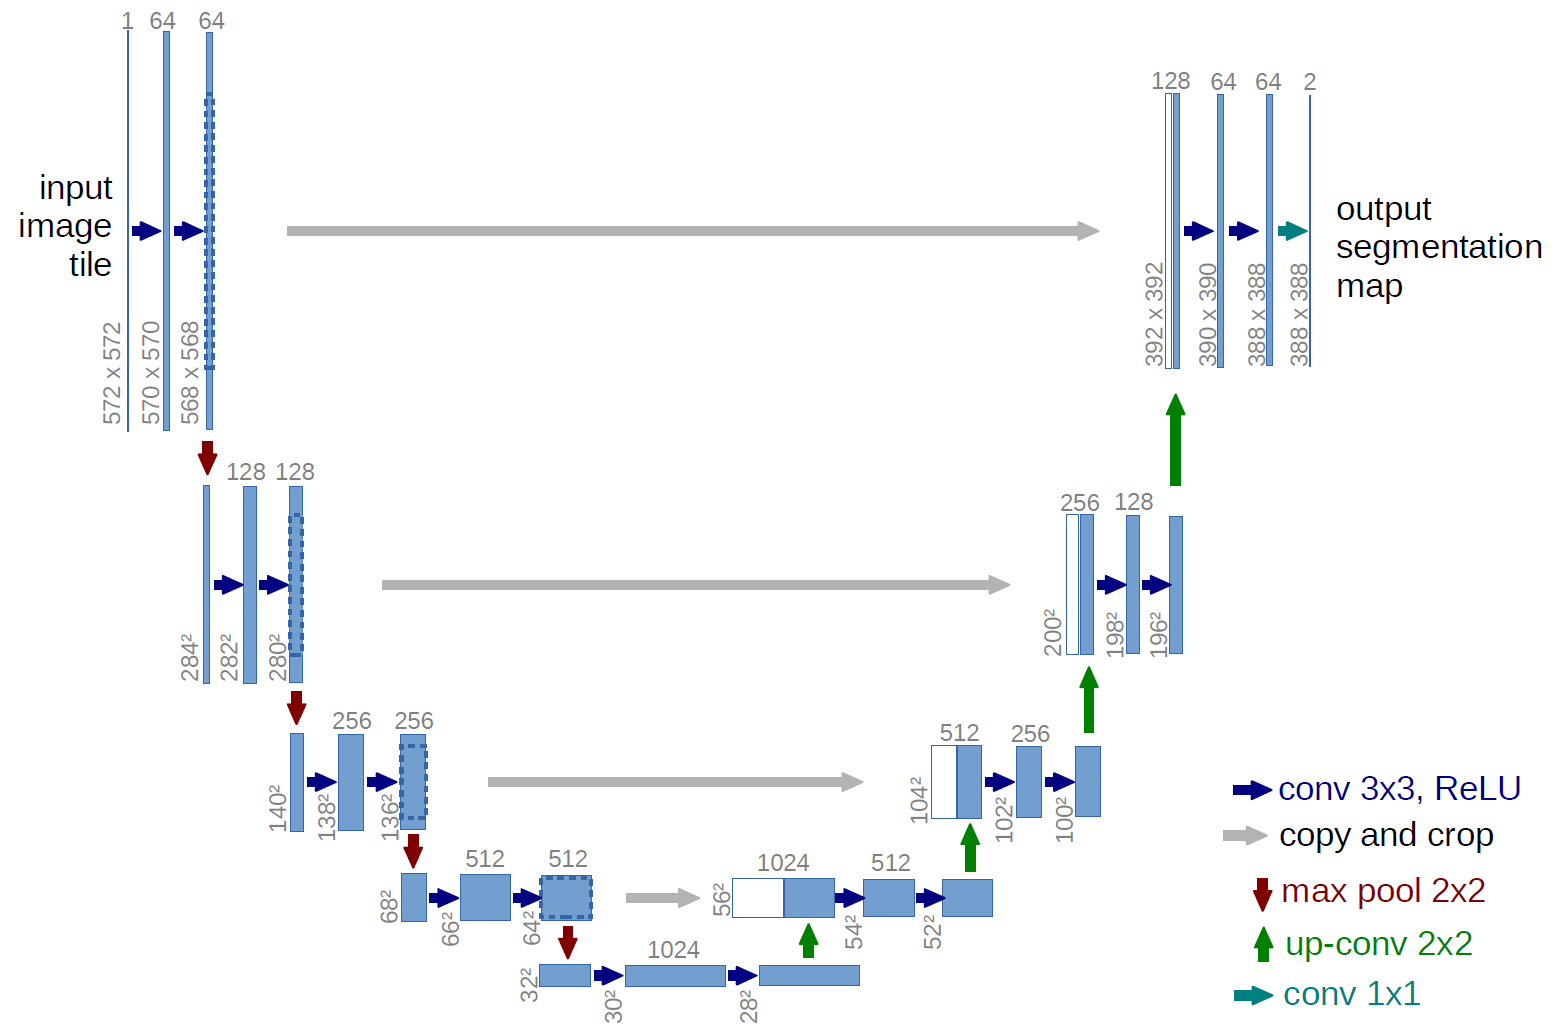

In [ ]:
# load weight to dictionary
# weights = {}
# for i, layer in enumerate(pretrain_model.layers):
#     if "conv2d" in layer.name: # has conved_tranpose in it
#       weights[i] = {"name":layer.name, "wei": layer.weights[0].numpy(),"bias": layer.weights[1].numpy()}
#     elif "batch_normalization" in layer.name:
#       weights[i] = {"name":layer.name, "gamma":layer.weights[0].numpy(),"beta":layer.weights[1].numpy(),"moving_mean":layer.weights[2].numpy(),"moving_var":layer.weights[3].numpy()  }   

In [ ]:
# for i, layer in enumerate(pretrain_model.layers):
#   print(i,layer.name)

In [ ]:
def conv_block(inputs, index):

    x = conv2D_v1(inputs, weights[index].wei, weights[index].bias, padding='same')
    x = batch_norm_v1(x, weights[index+1].gamma, weights[index+1].beta, weights[index+1].moving_mean, weights[index+1].moving_var)
    x = relu_v1(x)

    x = conv2D_v1(x, weights[index].wei, weights[index].bias, padding='same')
    x = batch_norm_v1(x, weights[index+1].gamma, weights[index+1].beta, weights[index+1].moving_mean, weights[index+1].moving_var)
    x = relu_v1(x)

    return x

In [ ]:
def encoder_block(inputs, index):
    x = conv_block(inputs, index)
    p = maxpool2d_v1(x, 2, 2)
    return x, p

In [ ]:
def decoder_block(inputs, index,  skip_features):
    x = trans_conv2D_v1(inputs, weights[index].wei, weights[index].bias)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, index)
    return x

In [ ]:
def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block(X, index) #64
    index +=7
    s2, p2 = encoder_block(p1,index ) #128
    index +=7
    s3, p3 = encoder_block(p2,index ) #256
    index +=7
    s4, p4 = encoder_block(p3,index ) #512
    index +=7
    b1 = conv_block(p4, index) #1024
    index +=6
    """ Decoder """
    d1 = decoder_block(b1, s4, index) #512
    index +=8
    d2 = decoder_block(d1, s3, index) #256
    index +=8
    d3 = decoder_block(d2, s2, index) #128
    index +=8
    d4 = decoder_block(d3, s1, index) #64 
    index +=8

    """ Output """
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    return outputs

## Cài đặt song song

### Thiết kế

## Tham khảo
1. https://betterdatascience.com/implement-pooling-from-scratch-in-python/
2. https://d2l.ai/chapter_computer-vision/transposed-conv.html
3. http://d2l.ai/chapter_convolutional-modern/batch-norm.html?highlight=batchnorm



In [ ]:
from numba import jit, prange, config, cuda
import math
from time import time

In [ ]:
print(cuda.detect())

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      compute capability: 7.5
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported
True


#### Activation ReLu Parallel

In [ ]:
@cuda.jit(debug=True) 
def relu_parallel(input, output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        if input[0, x, y, z] < 0: 
            output[0, x, y, z] = 0
        else: output[0, x, y, z] = input[0, x, y, z]

In [ ]:
before_ac = np.array(layer_outs[2])
after_ac = np.array(layer_outs[3])
res = np.zeros((before_ac.shape), dtype=float)

BLOCK_SIZE = (8, 8, 8)
GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
             math.ceil(res.shape[2]/BLOCK_SIZE[1]),
             math.ceil(res.shape[3]/BLOCK_SIZE[2]))

In [ ]:
%time relu_parallel[GRID_SIZE, BLOCK_SIZE](before_ac, res)
print("Checking difference",np.abs(res-after_ac).sum())

CPU times: user 218 ms, sys: 6.18 ms, total: 224 ms
Wall time: 225 ms
Checking difference 0.0


In [ ]:
%time relu_parallel[GRID_SIZE, BLOCK_SIZE](before_ac, res)

CPU times: user 30.5 ms, sys: 502 µs, total: 31 ms
Wall time: 31.1 ms


#### MaxPool Parallel

In [ ]:
@cuda.jit(debug=True)
def maxpool2d_parallel(input, output, pool, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        col = x * stride
        row = y * stride

        max = input[0, col, row, z]
        for i in range(pool):
            for j in range(pool):
                if input[0, col + i, row + j, z] > max:
                    max = input[0, col + i, row + j, z]

        output[0, x, y, z] = max

In [ ]:
before_maxpool = np.array(layer_outs[3])
after_maxpool = np.array(layer_outs[4])
pool = 2
stride = 2

w_out = (before_maxpool.shape[1] - pool)//stride + 1
h_out = (before_maxpool.shape[2] - pool)//stride + 1
pooled = np.zeros((1, w_out, h_out, before_maxpool.shape[3]))

%time maxpool2d_parallel[GRID_SIZE, BLOCK_SIZE](before_maxpool, pooled, pool, stride)
print("Checking difference",np.abs(pooled-after_maxpool).sum())

CPU times: user 250 ms, sys: 1.26 ms, total: 251 ms
Wall time: 252 ms
Checking difference 0.0


In [ ]:
%time maxpool2d_parallel[GRID_SIZE, BLOCK_SIZE](before_maxpool, pooled, pool, stride)

CPU times: user 18.1 ms, sys: 0 ns, total: 18.1 ms
Wall time: 17.5 ms
